# Data Challenge - Marubeni

### Submitted by: Saul Lee
### 2018-08-07

### Motivation:
Nearly a quarter of domestic flights in the U.S. are delayed or canceled; this costs your client,
American Airlines, billions of dollars per year. American Airlines’ executive leadership are
concerned about systemic inefficiencies that cause these delays and their impact on the public
perception of their brand versus their competitors.

### Goal: Analyze the data and provide actionable insights to the executive leadership at American Airlines
- Sources of the systematic inefficiencies that cause delays, recommendations to for mitigation
- Performance of AA versus other competitors

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
import missingno as msno
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, recall_score, precision_score
from datetime import timedelta
import itertools
%matplotlib inline

In [3]:
# define helper functions

def encodePD(inPD):
    """encode the categorical columns in a data frame into numerical values
    
    """
    outPD = pd.DataFrame()
    for key,val in inPD.iteritems():
        # check if the column is numeric, if not, encode the data
        if inPD[key].dtype == 'O':
            outPD[key],_ = encoder(val)
        else:
            outPD[key] = val
    
    return outPD

def encoder(inArray):
    """purpose: encode categorical data into numerical values
    
    """
    le = LabelEncoder()
    le.fit(inArray)
    encoded = le.transform(inArray)
    
    return encoded,le

def checkRowsMissing(in_df):
    """checks a dataframe for number of n/a values"""
    
    num_rows,num_cols = in_df.shape
    bool_mat = pd.DataFrame.isna(in_df)
    
    if num_cols > 1:
        # sum in axis=0 direction to get the distribution with respect to columns
        print("Missing data distribution\n\n{}\n".format(np.sum(bool_mat,axis=0)))
    
    # sum in axis=1 direction to get the number of rows missing
    bool_mat = np.sum(bool_mat,axis=1)
    num_missing = np.count_nonzero(bool_mat)
    print("{} out of {} rows with missing data, about {:0.2f} %".format(num_missing,num_rows,num_missing/num_rows * 100))
    
    #return num_missing,bool_mat


def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ("0", "1"), rotation=45)
    plt.yticks(tick_marks, ("0", "1"))


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def mergeAirports(in_airports,airports_merged):
    """function to convert the airports with the 5-digit FAA id to 3 letter IATA codes

    in_airports is a Series of airport codes
    airports_merged is a Series containing the 5-digit code in the index and the 3 letter codes in the data
    """
    
    converted_airports = in_airports.astype(str)
    converted_airports = converted_airports.map(airports_merged)
    temp_bool = converted_airports.isna()

    temp_list = []
    for i,val in enumerate(temp_bool):
        if val == False:
            temp_list.append(converted_airports.loc[i])
        else:
            temp_list.append(in_airports.loc[i])
    
        if (i % 250000 == 0):
            print(i)
    print("Done i = {}".format(i))
    
    return temp_list

def dayMarker(in_date,in_PD,offset=0):
    """function to marker a row to 1 if the date matches in_date
    
    in_date = datetime object containing the date of interest
    in_PD = Series or DataFrame where the date is contained within a column 'DATE'
    """
    if offset ==0:
        out_col = (in_PD['DATE'] == in_date).astype(int)
    else:
        offset=abs(offset)
        out_col = ((in_PD['DATE'] != in_date).values & \
                   (in_PD['DATE'] >= in_date - timedelta(days=offset)).values & \
                   (in_PD['DATE'] <= in_date + timedelta(days=offset)).values).astype(int)
    
    return out_col

def holidayMarker(in_holidays_PD,in_PD,offset_days=[0]):
    """function to mark holidays
    
    in_holidays_PD = DataFrame where the holidays are stored in a column 'DATE'
    in_PD = Series or DataFrame where the date is contained within a column 'DATE'
    offset_days = list containing days around the holiday to check for, default is zero
    """
    
    out_Array = np.zeros((in_PD.shape[0],len(offset_days)))
    
    for i,row in in_holidays_PD.iterrows():
        cur_date = row['DATE']
        for j,cur_offset in enumerate(offset_days):
            out_Array[:,j] = out_Array[:,j] + dayMarker(cur_date,in_PD,cur_offset)
    
    return out_Array

def extractDigits(in_Series):
    """ Extracts the hour and time from a 4 digit time code contained in a pandas series, returns 2 numpy arrays
    """
    # get rid of leading and trailing spaces
    temp_Series = in_Series.str.strip()
    
    # extract the hour and minute
    hour_Series = temp_Series.str.slice(start=0,stop=2).values.astype(float)
    minute_Series = temp_Series.str.slice(start=2,stop=4).values.astype(float)
    
    return hour_Series,minute_Series

## 1. Import data, clean, and preprocess

The flights data is contained in the csv file: 'flights.csv'

In [148]:
# read the data from the csv
raw_df = pd.read_csv('flights.csv',dtype={'SCHEDULED_DEPARTURE': str, 
                                          'DEPARTURE_TIME': str,
                                          'WHEELS_OFF':str,
                                          'WHEELS_ON':str,
                                          'SCHEDULED_ARRIVAL':str,
                                          'ARRIVAL_TIME':str
                                         })
raw_df.shape

/Users/sl1885/anaconda/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5819079, 31)

In [149]:
raw_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,...,0408,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,0010,...,0741,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,0020,...,0811,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,0020,...,0756,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,0025,...,0259,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1 Check for missing values

Let's check and visualize the data for missing values.

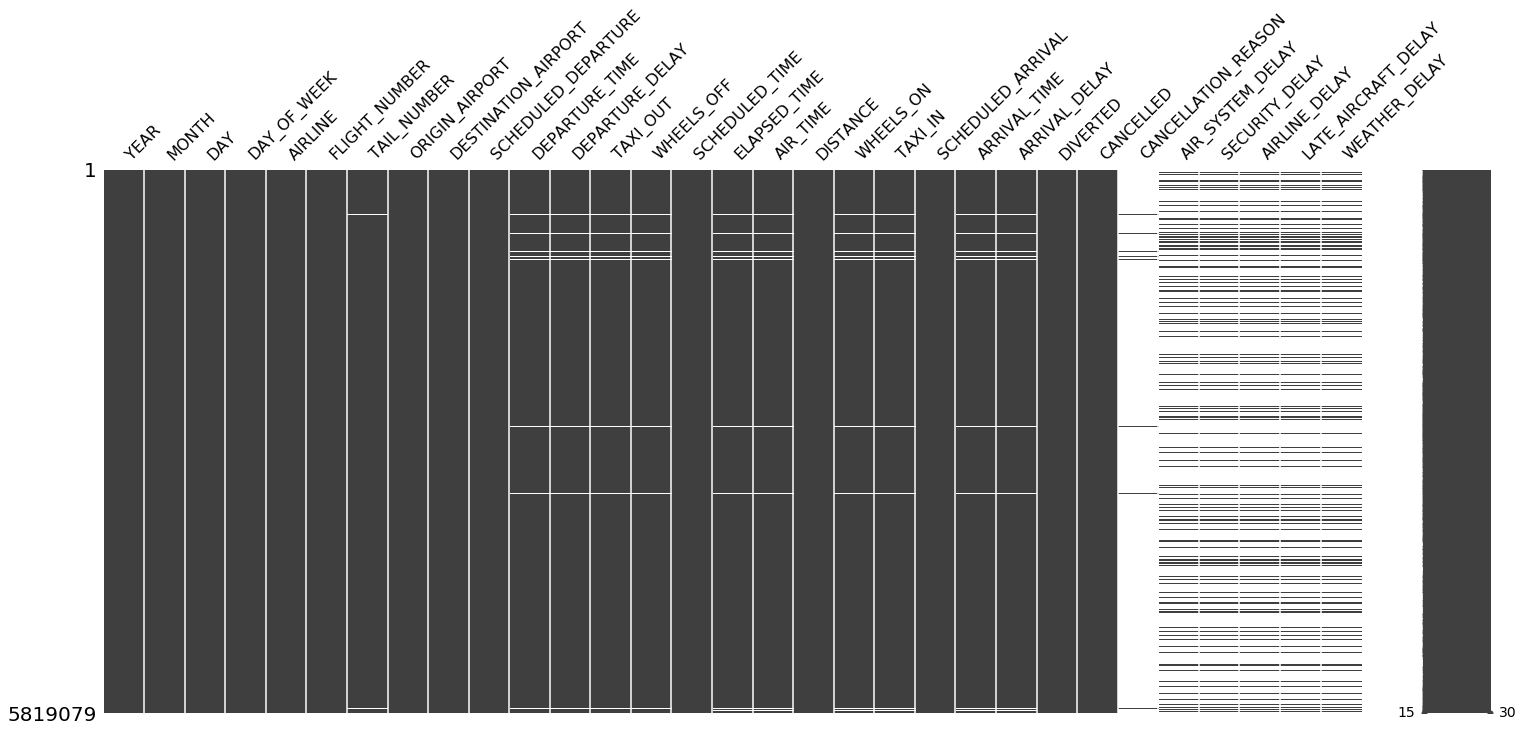

In [5]:
msno.matrix(raw_df)

In [6]:
# check for Data with N/A
checkRowsMissing(raw_df)

Missing data distribution

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

At a first glance, there are missing data in every row.  After visual inspection, this is due to the fact that there are 4 categories of flights (on-time/early, delayed, cancelled, or diverted).  Depending on the flight type, certain columns will be blank.  For example for an on-time/early flight, the columns "CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY" will be blank as the flight was not delayed or cancelled.  Conversely if a flight is cancelled, the columns "DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,TAXI_IN,ARRIVAL_TIME,ARRIVAL_DELAY" would be blank as a flight has not taken place.

### 1.2 Process 4 digit time

The time columns such as SCHEDULED_DEPARTURE contain the time in 4 digits.  Let's split that into 2 columns contain the hour and time.

In [150]:
# use the extractDigits function to convert the data
raw_df['SCHEDULED_DEPARTURE_hour'], raw_df['SCHEDULED_DEPARTURE_min'] = extractDigits(raw_df['SCHEDULED_DEPARTURE'])
raw_df['DEPARTURE_TIME_hour'], raw_df['DEPARTURE_TIME_min'] = extractDigits(raw_df['DEPARTURE_TIME'])
raw_df['WHEELS_OFF_hour'], raw_df['WHEELS_OFF_min'] = extractDigits(raw_df['WHEELS_OFF'])
raw_df['WHEELS_ON_hour'], raw_df['WHEELS_ON_min'] = extractDigits(raw_df['WHEELS_ON'])
raw_df['SCHEDULED_ARRIVAL_hour'], raw_df['SCHEDULED_ARRIVAL_min'] = extractDigits(raw_df['SCHEDULED_ARRIVAL'])
raw_df['ARRIVAL_TIME_hour'], raw_df['ARRIVAL_TIME_min'] = extractDigits(raw_df['ARRIVAL_TIME'])

In [151]:
raw_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DEPARTURE_TIME_hour,DEPARTURE_TIME_min,WHEELS_OFF_hour,WHEELS_OFF_min,WHEELS_ON_hour,WHEELS_ON_min,SCHEDULED_ARRIVAL_hour,SCHEDULED_ARRIVAL_min,ARRIVAL_TIME_hour,ARRIVAL_TIME_min
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,...,23.0,54.0,0.0,15.0,4.0,4.0,4.0,30.0,4.0,8.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,0010,...,0.0,2.0,0.0,14.0,7.0,37.0,7.0,50.0,7.0,41.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,0020,...,0.0,18.0,0.0,34.0,8.0,0.0,8.0,6.0,8.0,11.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,0020,...,0.0,15.0,0.0,30.0,7.0,48.0,8.0,5.0,7.0,56.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,0025,...,0.0,24.0,0.0,35.0,2.0,54.0,3.0,20.0,2.0,59.0


### 1.2 Airport codes
Visual inspection of the airport codes in the ORIGIN_AIRPORT and DESTINATION_AIRPORT revealed that some of the airport codes are the usual 3 letter IATA codes, e.g. JFK, while some are 5-digit FAA Identification codes, e.g. 12478 for JFK.

After some web searching, I found two tables from the Bureau of Transportation Statistics with the information.
https://www.transtats.bts.gov/Fields.asp

- The first table 'L_AIRPORT_ID' contains the 5-digit airport ID along with the name of the airport
- The second table 'AIRPORT' contains the 3 letter airport code along with the name of the airport

We will load the tables in here and join the two together using the airport name as the matching ids.

In [152]:
# read in the airport id table
airport_id = pd.read_csv('L_AIRPORT_ID.csv')
airport_id.shape

(6471, 2)

In [153]:
airport_id.head()

,Code,Description
0,10001,"Afognak Lake, AK: Afognak Lake Airport"
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10004,"Lik, AK: Lik Mining Camp"
3,10005,"Little Squaw, AK: Little Squaw Airport"
4,10006,"Kizhuyak, AK: Kizhuyak Bay"


In [154]:
# read in the airports table
airports = pd.read_csv('L_AIRPORT.csv')
airports.shape

(6489, 2)

In [155]:
airports.head()

,Code,Description
0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,04A,"Lik, AK: Lik Mining Camp"
3,05A,"Little Squaw, AK: Little Squaw Airport"
4,06A,"Kizhuyak, AK: Kizhuyak Bay"


In [156]:
airports_merged = airport_id.merge(airports,left_on='Description',right_on='Description',how='inner')
# drop duplicates in the airport_id
airports_merged = airports_merged.drop_duplicates('Code_x')
airports_merged = pd.Series(airports_merged['Code_y'].values,index=airports_merged['Code_x'].values.astype(str))
airports_merged.head()

10001    01A
10003    03A
10004    04A
10005    05A
10006    06A
dtype: object

In [157]:
converted_airports_origin = mergeAirports(raw_df['ORIGIN_AIRPORT'],airports_merged)

0
250000
500000
750000
1000000
1250000
1500000
1750000
2000000
2250000
2500000
2750000
3000000
3250000
3500000
3750000
4000000
4250000
4500000
4750000
5000000
5250000
5500000
5750000
Done i = 5819078


In [158]:
converted_airports_destination = mergeAirports(raw_df['DESTINATION_AIRPORT'],airports_merged)

0
250000
500000
750000
1000000
1250000
1500000
1750000
2000000
2250000
2500000
2750000
3000000
3250000
3500000
3750000
4000000
4250000
4500000
4750000
5000000
5250000
5500000
5750000
Done i = 5819078


In [159]:
# add the converted airports to the raw_df dataframe
raw_df['ORIGIN_AIRPORT_fixed'] = converted_airports_origin
raw_df['DESTINATION_AIRPORT_fixed'] = converted_airports_destination

In [160]:
# drop the original airports to save space
raw_df = raw_df.drop(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'],axis=1)

In [161]:
raw_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,WHEELS_OFF_hour,WHEELS_OFF_min,WHEELS_ON_hour,WHEELS_ON_min,SCHEDULED_ARRIVAL_hour,SCHEDULED_ARRIVAL_min,ARRIVAL_TIME_hour,ARRIVAL_TIME_min,ORIGIN_AIRPORT_fixed,DESTINATION_AIRPORT_fixed
0,2015,1,1,4,AS,98,N407AS,0005,2354,-11.0,...,0.0,15.0,4.0,4.0,4.0,30.0,4.0,8.0,ANC,SEA
1,2015,1,1,4,AA,2336,N3KUAA,0010,0002,-8.0,...,0.0,14.0,7.0,37.0,7.0,50.0,7.0,41.0,LAX,PBI
2,2015,1,1,4,US,840,N171US,0020,0018,-2.0,...,0.0,34.0,8.0,0.0,8.0,6.0,8.0,11.0,SFO,CLT
3,2015,1,1,4,AA,258,N3HYAA,0020,0015,-5.0,...,0.0,30.0,7.0,48.0,8.0,5.0,7.0,56.0,LAX,MIA
4,2015,1,1,4,AS,135,N527AS,0025,0024,-1.0,...,0.0,35.0,2.0,54.0,3.0,20.0,2.0,59.0,SEA,ANC


In [162]:
# save the conversions to file, to save computation time
raw_df[['ORIGIN_AIRPORT_fixed','DESTINATION_AIRPORT_fixed']].to_csv('converted_airports.csv',index=False)

In [163]:
# go ahead and build a encoder for later use
_ , airport_encoder = encoder(converted_airports_origin)

In [164]:
len(airport_encoder.classes_)

324

In [4]:
# write to disk for easier retrieval later
#raw_df.to_csv('flights_preprocessed.csv',index=False)
raw_df = pd.read_csv('flights_preprocessed.csv')
raw_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,WHEELS_OFF_hour,WHEELS_OFF_min,WHEELS_ON_hour,WHEELS_ON_min,SCHEDULED_ARRIVAL_hour,SCHEDULED_ARRIVAL_min,ARRIVAL_TIME_hour,ARRIVAL_TIME_min,ORIGIN_AIRPORT_fixed,DESTINATION_AIRPORT_fixed
0,2015,1,1,4,AS,98,N407AS,5,2354.0,-11.0,...,0.0,15.0,4.0,4.0,4.0,30.0,4.0,8.0,ANC,SEA
1,2015,1,1,4,AA,2336,N3KUAA,10,2.0,-8.0,...,0.0,14.0,7.0,37.0,7.0,50.0,7.0,41.0,LAX,PBI
2,2015,1,1,4,US,840,N171US,20,18.0,-2.0,...,0.0,34.0,8.0,0.0,8.0,6.0,8.0,11.0,SFO,CLT
3,2015,1,1,4,AA,258,N3HYAA,20,15.0,-5.0,...,0.0,30.0,7.0,48.0,8.0,5.0,7.0,56.0,LAX,MIA
4,2015,1,1,4,AS,135,N527AS,25,24.0,-1.0,...,0.0,35.0,2.0,54.0,3.0,20.0,2.0,59.0,SEA,ANC


In [13]:
_ , airport_encoder = encoder(raw_df['ORIGIN_AIRPORT_fixed'])

### 1.3 Feature Engineering

It will be helpful to define a few additional features:

It is useful to have the dates of the year.  However, the following features may be useful with respect to flight delays:
- proximity to federal holidays such as
    - New Year's Day (2015-01-01)
    - MLK Holiday (2015-01-19)
    - President's Day (2015-02-16)
    - Memorial Day (2015-05-25)
    - Independence Day (2015-07-04)
    - Labor Day (2015-09-07)
    - Columbus Day (2015-10-12)
    - Veteran's Day (2015-11-11)
    - Thanksgiving (2015-11-26)
    - Christmas (2015-12-25)

In [5]:
# pre-saved the dates in a csv file, create a new column for the DATE datetime object
holidays_df = pd.read_csv('federal_holidays.csv')
holidays_df['DATE'] = pd.to_datetime(holidays_df[['Year','Month','Day']])
holidays_df.head()

,Name,Year,Month,Day,DATE
0,New Year's Day,2015,1,1,2015-01-01
1,MLK Holiday,2015,1,19,2015-01-19
2,President's Day,2015,2,16,2015-02-16
3,Memorial Day,2015,5,25,2015-05-25
4,Independence Day,2015,7,4,2015-07-04


In [6]:
# generate new datetime object column
raw_df['DATE'] = pd.to_datetime(raw_df[['YEAR','MONTH','DAY']])

Create a few new columns
- Holiday, on the holiday
- Holiday_1, within +/- 1 day of the holiday
- Holiday_2, within +/- 2 day of the holiday
- Holiday_3, within +/- 3 day of the holiday
- Holiday_5, within +/- 5 day of the holiday

In [7]:
holiday_Array = holidayMarker(holidays_df,raw_df,[0,1,2,3,5])

In [8]:
raw_df['Holiday'] = holiday_Array[:,0]
raw_df['Holiday_1'] = holiday_Array[:,1]
raw_df['Holiday_2'] = holiday_Array[:,2]
raw_df['Holiday_3'] = holiday_Array[:,3]
raw_df['Holiday_5'] = holiday_Array[:,4]

In [9]:
raw_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,ARRIVAL_TIME_hour,ARRIVAL_TIME_min,ORIGIN_AIRPORT_fixed,DESTINATION_AIRPORT_fixed,DATE,Holiday,Holiday_1,Holiday_2,Holiday_3,Holiday_5
0,2015,1,1,4,AS,98,N407AS,5,2354.0,-11.0,...,4.0,8.0,ANC,SEA,2015-01-01,1.0,0.0,0.0,0.0,0.0
1,2015,1,1,4,AA,2336,N3KUAA,10,2.0,-8.0,...,7.0,41.0,LAX,PBI,2015-01-01,1.0,0.0,0.0,0.0,0.0
2,2015,1,1,4,US,840,N171US,20,18.0,-2.0,...,8.0,11.0,SFO,CLT,2015-01-01,1.0,0.0,0.0,0.0,0.0
3,2015,1,1,4,AA,258,N3HYAA,20,15.0,-5.0,...,7.0,56.0,LAX,MIA,2015-01-01,1.0,0.0,0.0,0.0,0.0
4,2015,1,1,4,AS,135,N527AS,25,24.0,-1.0,...,2.0,59.0,SEA,ANC,2015-01-01,1.0,0.0,0.0,0.0,0.0


Convert categorical data to encoded numerical data

In [10]:
raw_df.dtypes

YEAR                                  int64
MONTH                                 int64
DAY                                   int64
DAY_OF_WEEK                           int64
AIRLINE                              object
FLIGHT_NUMBER                         int64
TAIL_NUMBER                          object
SCHEDULED_DEPARTURE                   int64
DEPARTURE_TIME                      float64
DEPARTURE_DELAY                     float64
TAXI_OUT                            float64
WHEELS_OFF                          float64
SCHEDULED_TIME                      float64
ELAPSED_TIME                        float64
AIR_TIME                            float64
DISTANCE                              int64
WHEELS_ON                           float64
TAXI_IN                             float64
SCHEDULED_ARRIVAL                     int64
ARRIVAL_TIME                        float64
ARRIVAL_DELAY                       float64
DIVERTED                              int64
CANCELLED                       

In [11]:
# convert categorical data to encoded values
raw_df['AIRLINE_enc'], AIRLINE_encoder = encoder(raw_df['AIRLINE'].astype(str))
raw_df['TAIL_NUMBER_enc'], TAIL_NUMBER_encoder = encoder(raw_df['TAIL_NUMBER'].astype(str))

In [14]:
# we already have an encoder for the AIRPORT.  we will use the same one so the codes are the same
raw_df['ORIGIN_AIRPORT_enc'] = airport_encoder.transform(raw_df['ORIGIN_AIRPORT_fixed'].values)

In [15]:
raw_df['DESTINATION_AIRPORT_enc'] = airport_encoder.transform(raw_df['DESTINATION_AIRPORT_fixed'].values)

In [16]:
raw_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,DATE,Holiday,Holiday_1,Holiday_2,Holiday_3,Holiday_5,AIRLINE_enc,TAIL_NUMBER_enc,ORIGIN_AIRPORT_enc,DESTINATION_AIRPORT_enc
0,2015,1,1,4,AS,98,N407AS,5,2354.0,-11.0,...,2015-01-01,1.0,0.0,0.0,0.0,0.0,1,1622,17,279
1,2015,1,1,4,AA,2336,N3KUAA,10,2.0,-8.0,...,2015-01-01,1.0,0.0,0.0,0.0,0.0,0,1556,177,237
2,2015,1,1,4,US,840,N171US,20,18.0,-2.0,...,2015-01-01,1.0,0.0,0.0,0.0,0.0,11,421,280,66
3,2015,1,1,4,AA,258,N3HYAA,20,15.0,-5.0,...,2015-01-01,1.0,0.0,0.0,0.0,0.0,0,1516,177,204
4,2015,1,1,4,AS,135,N527AS,25,24.0,-1.0,...,2015-01-01,1.0,0.0,0.0,0.0,0.0,1,2131,279,17


## 2. Flight Types

The data set contains information for flights that can be separated into three different groups
- on-time/delayed/early
- cancelled
- diverted).

In [17]:
# count the number of diverted flights
raw_df['DIVERTED'].value_counts()

0    5803892
1      15187
Name: DIVERTED, dtype: int64

### 2.1 Diverted and Cancelled Flights
Next let's examine the 'DIVERTED' and 'CANCELLED' flights.

In [18]:
# count the number of cancelled flights
raw_df['CANCELLED'].value_counts()

0    5729195
1      89884
Name: CANCELLED, dtype: int64

In [19]:
# count the number of flights where both the diverted and cancelled are 1
count = 0
for row in raw_df.itertuples():
    if row.DIVERTED == 1 and row.CANCELLED == 1:
        print(row[0])
        count += count

print("Number of Diverted and Cancelled Found where both are 1 = {}".format(count))

Number of Diverted and Cancelled Found where both are 1 = 0


In [20]:
# total number of diverted and cancelled flights
raw_df['DIVERTED'].value_counts().loc[1] + raw_df['CANCELLED'].value_counts().loc[1]

105071

In [21]:
# check the 6 missing values SCHEDULED_TIME
raw_df[raw_df['SCHEDULED_TIME'].isna()]

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,DATE,Holiday,Holiday_1,Holiday_2,Holiday_3,Holiday_5,AIRLINE_enc,TAIL_NUMBER_enc,ORIGIN_AIRPORT_enc,DESTINATION_AIRPORT_enc
483174,2015,2,1,7,NK,416,N627NK,2215,2206.0,-9.0,...,2015-02-01,0.0,0.0,0.0,0.0,0.0,8,2706,114,151
619941,2015,2,10,2,NK,416,N632NK,2215,2206.0,-9.0,...,2015-02-10,0.0,0.0,0.0,0.0,0.0,8,2741,114,151
1720237,2015,4,20,1,NK,174,N630NK,1602,1857.0,175.0,...,2015-04-20,0.0,0.0,0.0,0.0,0.0,8,2728,114,183
1820960,2015,4,26,7,NK,720,N614NK,2059,2057.0,-2.0,...,2015-04-26,0.0,0.0,0.0,0.0,0.0,8,2626,85,86
2031482,2015,5,9,6,NK,324,N620NK,2130,2152.0,22.0,...,2015-05-09,0.0,0.0,0.0,0.0,0.0,8,2661,194,8
2034453,2015,5,10,7,NK,368,N534NK,825,1214.0,229.0,...,2015-05-10,0.0,0.0,0.0,0.0,0.0,8,2171,230,51


In [22]:
# check the number of flights with missing TAIL_NUMBER are cancelled flights
raw_df[raw_df['TAIL_NUMBER'].isna()]['CANCELLED'].value_counts()

1    14721
Name: CANCELLED, dtype: int64

There are 15187 diverted (designated by a value of 1 in the 'DIVERTED' column) and 89884 cancelled (designated by a value of 1 in the 'CANCELLED' column) flights which account for 0.3 % and 1.5 %, respectively.  Further checking for the rows with missing 'TAIL_NUMBER' values are all confirms that they are all cancelled flights.  The 6 rows with missing values in SCHEDULED_TIME are either cancelled or diverted flights.

Since the flights can be separated into three different groups (on-time/delayed/early,cancelled,diverted) with different data compositions, it makes sense to split the original data frame into 3 sub data frames

In [23]:
# split the dataframe for diverted
df_diverted = raw_df[raw_df['DIVERTED'] == 1]
df_diverted.shape

(15187, 53)

In [24]:
# split the dataframe cancelled
df_cancelled = raw_df[raw_df['CANCELLED'] == 1]
df_cancelled.shape

(89884, 53)

In [25]:
# split the dataframe
df_delayed = raw_df[(raw_df['CANCELLED'] == 0).values & (raw_df['DIVERTED'] == 0).values]
df_delayed.shape

(5714008, 53)

### 2.2 Flight Delays

Since the diverted and cancelled flights account for very small percentage of the total flights in 2015, let's examine the flight delay data frame first.

In [26]:
# check again for Data with N/A
checkRowsMissing(df_delayed)

Missing data distribution

YEAR                               0
MONTH                              0
DAY                                0
DAY_OF_WEEK                        0
AIRLINE                            0
FLIGHT_NUMBER                      0
TAIL_NUMBER                        0
SCHEDULED_DEPARTURE                0
DEPARTURE_TIME                     0
DEPARTURE_DELAY                    0
TAXI_OUT                           0
WHEELS_OFF                         0
SCHEDULED_TIME                     0
ELAPSED_TIME                       0
AIR_TIME                           0
DISTANCE                           0
WHEELS_ON                          0
TAXI_IN                            0
SCHEDULED_ARRIVAL                  0
ARRIVAL_TIME                       0
ARRIVAL_DELAY                      0
DIVERTED                           0
CANCELLED                          0
CANCELLATION_REASON          5714008
AIR_SYSTEM_DELAY             4650569
SECURITY_DELAY               4650569
AIRLINE_DEL

The missing values are only in the columns "CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY"

We can now begin to drop non-relevant/unnecessary data columns

- DIVERTED, CANCELLED and CANCELLATION_REASON: these are not necssary since non of the flights in this data frame are from diverted or cancelled flights
- ELAPSED_TIME: from the definition ELAPSED_TIME is a combination of AIR_TIME+TAXI_IN+TAXI_OUT which is correlated with other those columns

In [27]:
df_delayed = df_delayed.drop(['DIVERTED','CANCELLED',
                              'CANCELLATION_REASON',
                              'ELAPSED_TIME'],axis=1)
df_delayed.shape

(5714008, 49)

In [28]:
# check again for Data with N/A
checkRowsMissing(df_delayed)

Missing data distribution

YEAR                               0
MONTH                              0
DAY                                0
DAY_OF_WEEK                        0
AIRLINE                            0
FLIGHT_NUMBER                      0
TAIL_NUMBER                        0
SCHEDULED_DEPARTURE                0
DEPARTURE_TIME                     0
DEPARTURE_DELAY                    0
TAXI_OUT                           0
WHEELS_OFF                         0
SCHEDULED_TIME                     0
AIR_TIME                           0
DISTANCE                           0
WHEELS_ON                          0
TAXI_IN                            0
SCHEDULED_ARRIVAL                  0
ARRIVAL_TIME                       0
ARRIVAL_DELAY                      0
AIR_SYSTEM_DELAY             4650569
SECURITY_DELAY               4650569
AIRLINE_DELAY                4650569
LATE_AIRCRAFT_DELAY          4650569
WEATHER_DELAY                4650569
SCHEDULED_DEPARTURE_hour           0
SCHEDULED_D

For the remaining missing values in the columns "AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY", let's assume those are flights that are not delayed.  We can fill those values in with zeros.

In [29]:
df_delayed = df_delayed.fillna(0)

Lets generate the target labels.  We will define delayed flight as flights that have ARRIVAL_DELAY > 0.

In [30]:
y_labels = (df_delayed['ARRIVAL_DELAY'] > 0).astype(float)

For all flights, 63.48 % of the flights are on-time/early, 36.52 % of the flights are delayed


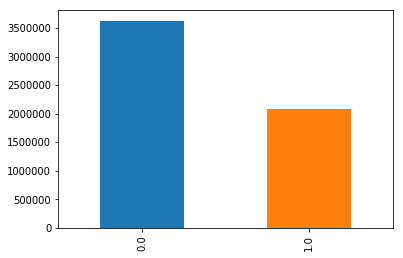

In [31]:
# check for class imbalance
counts = y_labels.value_counts()
counts.plot.bar()
print("For all flights, {:.2f} % of the flights are on-time/early, {:.2f} % of the flights are delayed".format( 
      (counts.loc[0.0]/y_labels.shape[0]*100),\
     (counts.loc[1.0]/y_labels.shape[0]*100)))

The classes are imbalanced.  This will be dealt with later.

## 2. Data visualization

Let's visualize the data:

In [32]:
# let's plot the distribution of the flight types
ontime_counts = np.sum(y_labels==0)
delayed_counts = np.sum(y_labels==1)
cancelled_counts = df_cancelled.shape[0]
diverted_counts = df_diverted.shape[0]
total_counts = ontime_counts + delayed_counts + cancelled_counts + diverted_counts

(-1.1130984572382372,
 1.117862235984605,
 -1.1180434783766209,
 1.1129172148462214)

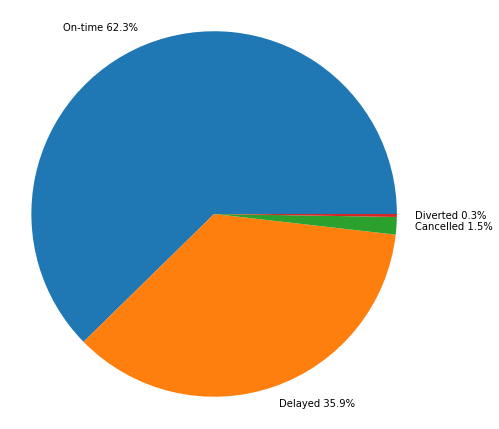

In [33]:
fig, axes = plt.subplots(1,1,figsize=(10,7.5))
labels = ['On-time {:.1f}%'.format(ontime_counts/total_counts*100),
          'Delayed {:.1f}%'.format(delayed_counts/total_counts*100),
          'Cancelled {:.1f}%'.format(cancelled_counts/total_counts*100),
          'Diverted {:.1f}%'.format(diverted_counts/total_counts*100)]
plt.pie([ontime_counts,delayed_counts,cancelled_counts,diverted_counts],labels=labels)
plt.axis('square') 

The fraction of diverted and cancelled flights are much smaller than the fraction of delayed flights.

Next we will look at cancelled flights

Text(0.5,0,'Number of Cancellations')

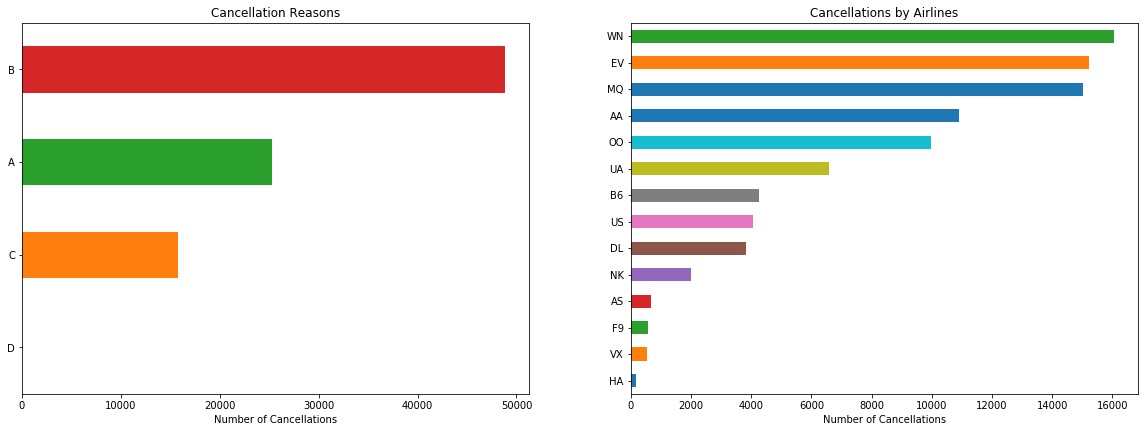

In [34]:
fig, axes = plt.subplots(1,2,figsize=(20,15))
plt.subplot(2,2,1)
df_cancelled['CANCELLATION_REASON'].value_counts()[::-1].plot.barh()
df_cancelled['CANCELLATION_REASON'].value_counts()
plt.title('Cancellation Reasons')
plt.xlabel('Number of Cancellations')
plt.subplot(2,2,2)
df_cancelled['AIRLINE'].value_counts()[::-1].plot.barh()
df_cancelled['AIRLINE'].value_counts()
plt.title('Cancellations by Airlines')
plt.xlabel('Number of Cancellations')

Reason for Cancellation of flight: 
- A - Airline/Carrier 
- B - Weather
- C - National Air System;
- D - Security

Airline Codes:
IATA_CODE,AIRLINE
- UA,United Air Lines Inc.
- AA,American Airlines Inc.
- US,US Airways Inc.
- F9,Frontier Airlines Inc.
- B6,JetBlue Airways
- OO,Skywest Airlines Inc.
- AS,Alaska Airlines Inc.
- NK,Spirit Air Lines
- WN,Southwest Airlines Co.
- DL,Delta Air Lines Inc.
- EV,Atlantic Southeast Airlines
- HA,Hawaiian Airlines Inc.
- MQ,American Eagle Airlines Inc.
- VX,Virgin America

Weather is by far the most prevalent cause of flight cancellation followed by Airline/Carrier.  Southwest airlines 'WN' had the most cancellations.  American Airlines has the 4th highest number of cancellations.  However, American Eagle Airlines, Inc. which is a regional marketing brand of American Airlines had the 3rd highest number of cancellations.  Since American Airlines only has partial of the regional airline, we will focus on Americal Airline flights

WN    3409
AA    2130
EV    1994
DL    1782
OO    1579
UA    1388
MQ     816
B6     730
US     425
AS     413
NK     182
F9     158
VX     121
HA      60
Name: AIRLINE, dtype: int64

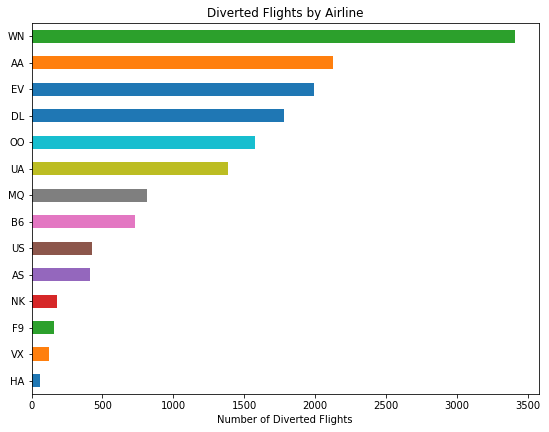

In [35]:
# Plot the diverted flights
fig, axes = plt.subplots(1,1,figsize=(20,15))
plt.subplot(2,2,1)
df_diverted['AIRLINE'].value_counts()[::-1].plot.barh()
plt.title('Diverted Flights by Airline')
plt.xlabel('Number of Diverted Flights')
df_diverted['AIRLINE'].value_counts()

American Airlines has the 2nd highest number of diverted flights after Southwest.

WN    470767
AA    252191
DL    250840
OO    222435
EV    213217
UA    186227
MQ    103505
B6    101998
US     76285
AS     56953
NK     56887
F9     41232
HA     30179
VX     24180
Name: AIRLINE, dtype: int64

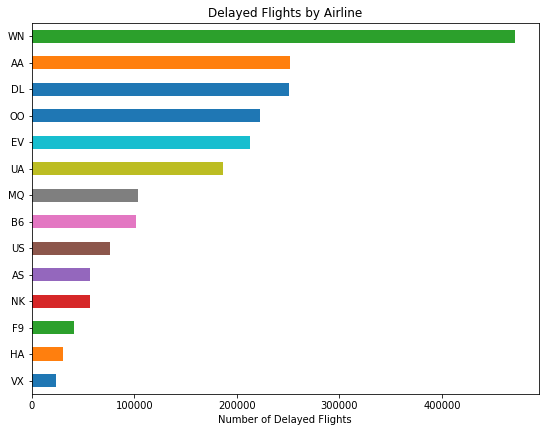

In [36]:
# Plot the delayed flights
fig, axes = plt.subplots(1,1,figsize=(20,15))
plt.subplot(2,2,1)
df_delayed[y_labels==1]['AIRLINE'].value_counts()[::-1].plot.barh()
plt.title('Delayed Flights by Airline')
plt.xlabel('Number of Delayed Flights')
df_delayed[y_labels==1]['AIRLINE'].value_counts()

American Airlines has the 2nd highest number of delayed flights after Southwest.  However, the number is on par with Delta with United Airlines not far behind.

Next we will groupby various columns in the data to visualize the distribution and the effect of the columns.

In [37]:
# lets examine the delayed flights
grouped = df_delayed[y_labels == 1].groupby(['AIRLINE'])['ARRIVAL_DELAY']

[0, 150, 0, 200000]

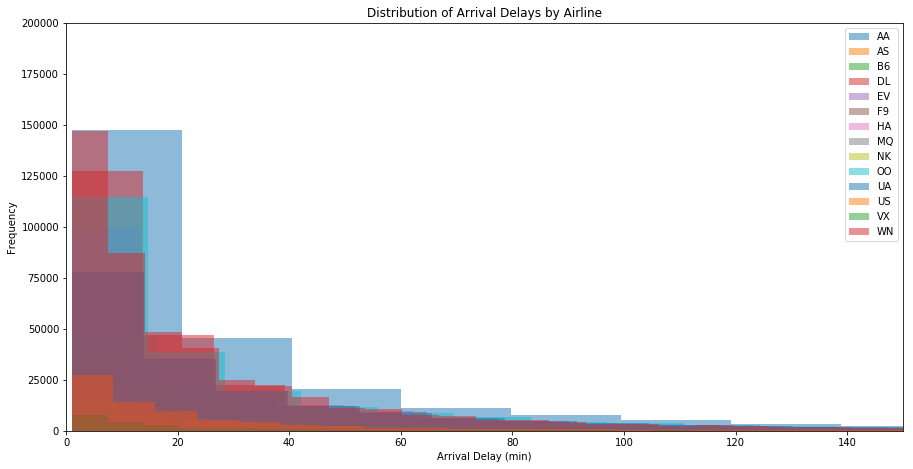

In [80]:
grouped.plot.hist(bins=100,stacked=True,alpha=0.5,figsize=(15,7.5))
plt.legend()
plt.title('Distribution of Arrival Delays by Airline')
plt.xlabel('Arrival Delay (min)')
plt.axis([0,150,0,200000])

AIRLINE
HA    15.379767
AS    22.562411
US    27.419925
WN    29.418496
VX    30.725227
DL    32.077424
OO    32.437278
AA    34.148364
EV    35.198042
B6    38.132807
UA    39.209314
MQ    39.509202
NK    40.659852
F9    41.190435
Name: ARRIVAL_DELAY, dtype: float64

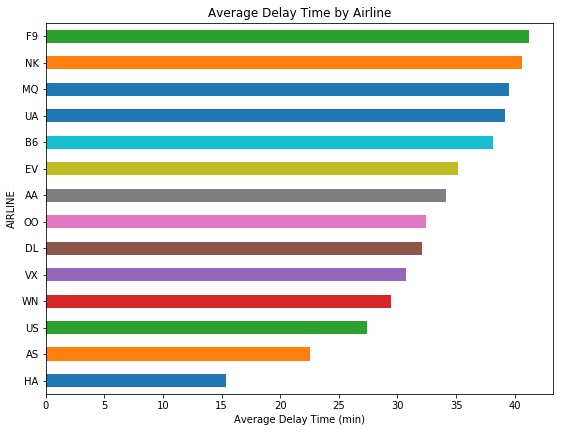

In [70]:
# Plot the delayed flights average delayed time
fig, axes = plt.subplots(1,1,figsize=(20,15))
plt.subplot(2,2,1)
grouped.mean().sort_values(ascending=True).plot.barh()
plt.title('Average Delay Time by Airline')
plt.xlabel('Average Delay Time (min)')
grouped.mean().sort_values(ascending=True)

Plotting the average delay time shows that American Airlines has an average delay time of 34 min.  Hawaiian Airlines had the shortest delay time of 15 min, while JetBlue had the longest at 41 min.

Similary to the company plot, grouping by department,seniority, and salary show similar length at company trends.  The strongest peak is around 365 days with the second grouping peaking at around 730 days.  The peaks are higher at company one because they also have more employees in the data.

## 3. Model Fitting: Delayed Flights


### 3.1 Data Preparation
Since we are mainly interested in understanding the performance of American Airline flights, we will focus the study on AA delayed flights.

We would like to understand the important factors that cause the delays.

For the X feature matrix, we will drop non-related, previously encoded columns.  Additionally we will drop the DEPARTURE_DELAY column as it is the strongest predictor of flight delays.  However, it is likely a source of data leakage and it doesn't really tell us why the flight is delayed.

In [81]:
# get the data frame just for AA, drop the non numerical columns that were previously encoded
df_delayed_AA = df_delayed[df_delayed['AIRLINE'] == 'AA']
X_delayed_AA = df_delayed_AA.drop(['AIRLINE',
                                   'TAIL_NUMBER',
                                   'ORIGIN_AIRPORT_fixed',
                                   'DESTINATION_AIRPORT_fixed',
                                   'ARRIVAL_DELAY',
                                   'DEPARTURE_DELAY',
                                   'SCHEDULED_DEPARTURE',
                                   'DEPARTURE_TIME',
                                   'WHEELS_OFF',
                                   'WHEELS_ON',
                                   'SCHEDULED_ARRIVAL',
                                   'ARRIVAL_TIME',
                                    'DATE'],axis=1)

In [56]:
X_delayed_AA.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAXI_OUT,SCHEDULED_TIME,AIR_TIME,DISTANCE,TAXI_IN,...,ARRIVAL_TIME_min,Holiday,Holiday_1,Holiday_2,Holiday_3,Holiday_5,AIRLINE_enc,TAIL_NUMBER_enc,ORIGIN_AIRPORT_enc,DESTINATION_AIRPORT_enc
1,2015,1,1,4,2336,12.0,280.0,263.0,2330,4.0,...,41.0,1.0,0.0,0.0,0.0,0.0,0,1556,177,237
3,2015,1,1,4,258,15.0,285.0,258.0,2342,8.0,...,56.0,1.0,0.0,0.0,0.0,0.0,0,1516,177,204
8,2015,1,1,4,1112,17.0,195.0,173.0,1464,3.0,...,32.0,1.0,0.0,0.0,0.0,0.0,0,1561,280,86
11,2015,1,1,4,1674,21.0,268.0,238.0,2174,7.0,...,53.0,1.0,0.0,0.0,0.0,0.0,0,4110,175,204
21,2015,1,1,4,371,30.0,338.0,311.0,2724,6.0,...,39.0,1.0,0.0,0.0,0.0,0.0,0,1493,279,204


In [57]:
y_labels_AA = y_labels[df_delayed['AIRLINE'] == 'AA']

For all flights, 64.63 % of the flights are on-time/early, 35.37 % of the flights are delayed


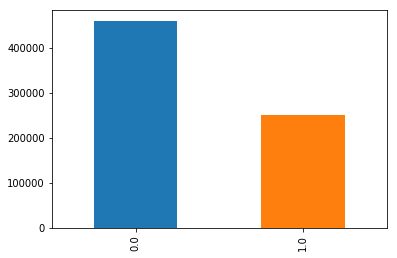

In [58]:
# check for class imbalance
counts = y_labels_AA.value_counts()
counts.plot.bar()
print("For all flights, {:.2f} % of the flights are on-time/early, {:.2f} % of the flights are delayed".format( 
      (counts.loc[0.0]/y_labels_AA.shape[0]*100),\
     (counts.loc[1.0]/y_labels_AA.shape[0]*100)))

Similar to the data with all the airlines, there is a class imbalance.  We will subsample the data to balance the classes.

In [59]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X_delayed_AA,np.array(y_labels_AA),
                                                    test_size = 0.25,
                                                    random_state = 42)

In [60]:
# balance the classes in the training set, subsample the negative class to match the number of positive class
composite = X_train
composite['labels'] = y_train.reshape(-1,1)

/Users/sl1885/anaconda/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
composite_negative = composite[composite['labels'] == 0]
composite_negative.shape

(345393, 37)

In [62]:
composite_positive = composite[composite['labels'] == 1]
composite_positive.shape

(189308, 37)

In [63]:
from sklearn.utils import resample
n_samples = composite_positive.shape[0]
composite_negative_ds = resample(composite_negative,
                       replace=False,
                       n_samples=n_samples,
                       random_state =10
                      )
composite_negative_ds.shape

(189308, 37)

In [64]:
composite_ds = pd.concat([composite_negative_ds,composite_positive])
X_train = np.array(composite_ds.drop('labels',axis=1))
y_train = np.array(composite_ds['labels'])

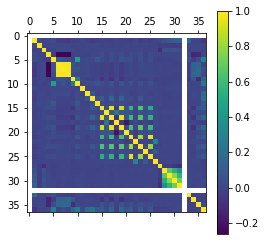

In [99]:
# Plot the correlation matrix
corr = composite_ds.corr()
plt.matshow(corr)
plt.colorbar()

The correlation matrix shows many regions of high collinearity.  We will have to use methods other than linear models.

Plot the data to check that the classes are balanced

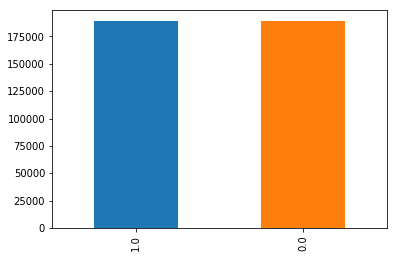

In [65]:
composite_ds['labels'].value_counts().plot.bar()

In [66]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (378616, 36)
Training Labels Shape: (378616,)
Testing Features Shape: (178234, 36)
Testing Labels Shape: (178234,)


### 3.2 Naive/Baseline Model

For the naive/baseline model, we will chose random guessing.  We will select the F1 Score as the evaluation metric.

In [85]:
y_pred_rand = np.random.randint(2,size=y_test.shape)

Normalized confusion matrix
[[0.5 0.5]
 [0.5 0.5]]


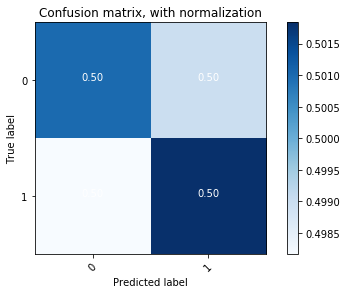

In [86]:
# generate and plot the confusion matrix
cnf_matrix  = confusion_matrix(y_test, y_pred_rand)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
title='Confusion matrix, with normalization')

In [87]:
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred_rand)))
print("Recall score: {:.2f}".format(recall_score(y_test, y_pred_rand)))
print("Precision score: {:.2f}".format(precision_score(y_test, y_pred_rand)))

F1 score: 0.42
Recall score: 0.50
Precision score: 0.35


The naive model of random guessing had an F1 score of 0.42. As expected, it predicted half of the labels.

### 3.3 Random Forest Model

Since the correlation matrix revealed several variables with high correlation, we will use a random forest classifier to fit the data.

We will use GridSearchCV to assist with the parameter selection.

In [67]:
# Setup the Random Forest Model with Grid Search to find a good first pass model
rf = RandomForestClassifier(random_state = 42,class_weight="balanced")
parameters = {'n_estimators':[10,50,100,200,500],
              'max_depth':[3,5,7,10]
             }

clf = GridSearchCV(rf, parameters,cv = 3,n_jobs=-1,return_train_score=True,scoring='f1')

In [68]:
# run the model with the training data
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100, 200, 500], 'max_depth': [3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [69]:
# view the CV results
clf.cv_results_

{'mean_fit_time': array([  4.95683932,  16.64463107,  30.06301268,  59.83913906,
        144.40424164,   5.42146301,  22.94329739,  43.60862637,
         95.23139675, 219.72444256,   7.06109929,  30.11580642,
         56.17861835, 116.47318308, 289.76199961,   9.05814719,
         39.12994361,  80.44200301, 180.5701201 , 359.76106429]),
 'std_fit_time': array([ 0.13538629,  0.27797666,  0.48998023,  0.70528159,  0.99803368,
         0.06695387,  0.47894994,  0.21907035,  0.46122933,  3.09585748,
         0.10962839,  0.10416481,  0.71975446,  0.17710092,  2.86451532,
         0.1158985 ,  0.07389602,  2.99081632,  4.75285186, 37.76922023]),
 'mean_score_time': array([0.30198193, 0.673877  , 1.20012434, 2.47301157, 6.41127642,
        0.27220265, 0.80897442, 1.45528261, 2.71634094, 6.60487819,
        0.27107509, 0.85421689, 1.4905467 , 3.07636293, 7.90609455,
        0.29901139, 1.0197173 , 1.91597637, 4.45082823, 6.43311667]),
 'std_score_time': array([0.02400391, 0.06320526, 0.026814

The cross validation results from GridsearchCV shows that the depth of the tree had more effect on the f1 score than the number of estimators (tree).  No significant increase in the score was observed above 100 estimators, this is the number we will use.  We will choose the max_depth to be 10.

In [100]:
rf_best = RandomForestClassifier(random_state = 42,max_depth=10,n_estimators=100,class_weight="balanced")

In [101]:
rf_best.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [102]:
y_pred_rf = rf_best.predict(X_test)

In [105]:
print("The accuracy score for the model is  {:.2f}".format(rf_best.score(X_test,y_test)))

The accuracy score for the model is  0.85


Normalized confusion matrix
[[0.96 0.04]
 [0.34 0.66]]


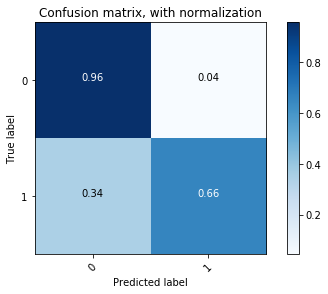

In [106]:
# generate and plot the confusion matrix
cnf_matrix  = confusion_matrix(y_test, y_pred_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
title='Confusion matrix, with normalization')

In [107]:
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred_rf)))
print("Recall score: {:.2f}".format(recall_score(y_test, y_pred_rf)))
print("Precision score: {:.2f}".format(precision_score(y_test, y_pred_rf)))

F1 score: 0.76
Recall score: 0.66
Precision score: 0.89


In [108]:
y_proba_rf = rf_best.predict_proba(X_test)

In [109]:
# compute and ROC curve and AUC_ROC score
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test,y_proba_rf[:,1])

# compute the auc_roc
auc_roc = auc(fpr,tpr)
print("The auc_roc score is {:.2f}".format(auc_roc))

The auc_roc score is 0.89


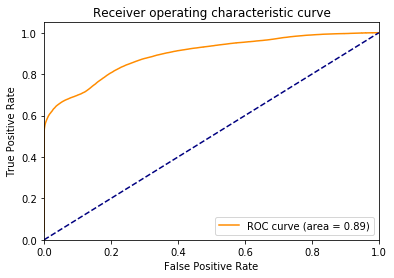

In [110]:
# plot the ROC curve
plt.plot(fpr,tpr,color='darkorange',
        label='ROC curve (area = {:0.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

In [111]:
feature_importances = pd.DataFrame(rf_best.feature_importances_,
                                   index = X_delayed_AA.columns,
                                    columns=['Importance']).sort_values('Importance',ascending=False)

In [112]:
feature_importances

,Importance
AIRLINE_DELAY,0.259810
AIR_SYSTEM_DELAY,0.253704
LATE_AIRCRAFT_DELAY,0.192309
TAXI_OUT,0.111029
TAXI_IN,0.038117
WEATHER_DELAY,0.024089
SCHEDULED_ARRIVAL_min,0.017102
WHEELS_OFF_hour,0.011917
ARRIVAL_TIME_hour,0.011275
DEPARTURE_TIME_hour,0.010951


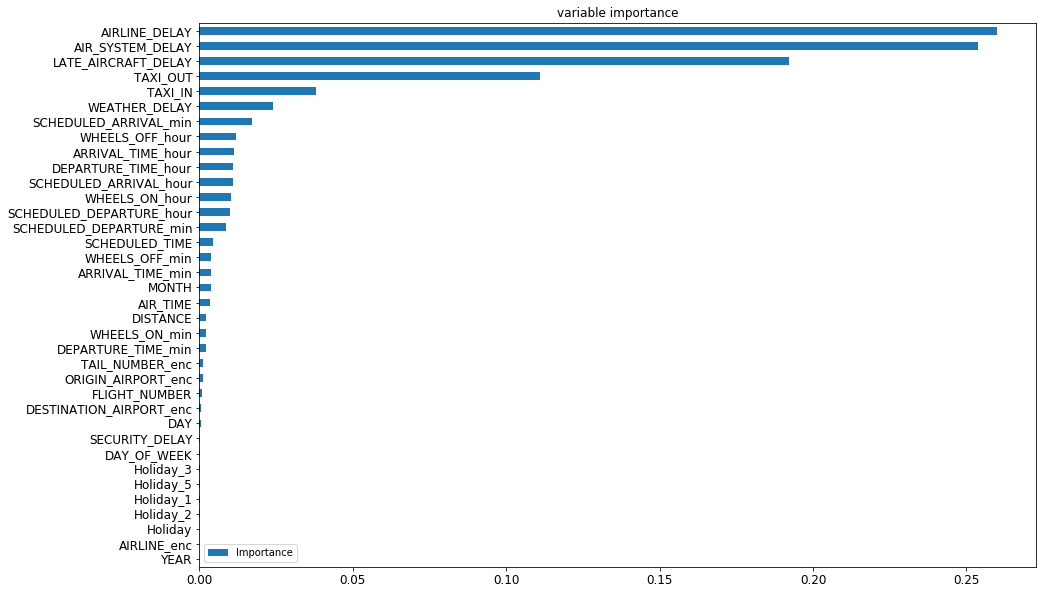

In [113]:
ax = feature_importances[::-1].plot(kind='barh', title ="variable importance", figsize=(15, 10), fontsize=12)

The random forest classifier performed better than the naive model with an f1 score of 0.76 compared to 0.42 for the naive model.  However, while it did okay on the precision score (0.89), the recall score was not as good (0.66) as it predicted a lot of false negatives.

The feature importances show that the most important feature in predicting delays is AIRLINE_DELAY followed by AIR_SYSTEM, LATE_AIRCRAFT, TAXI_OUT and WEATHER_DELAY.  Some of these factors maybe confounded.

It is interesting to note that the proximity to holidays was not an important feature in predicting delays or the airport.

## 4. Summary and Recommendations

### Summary:
In 2015, the passenger airline industry in the US had an on-time rate of 62.3 %.  The non on-time flights were composed of delayed (35.9 %), cancelled (1.5 %), and diverted (0.3 %) flights.

While not the worst, American Airlines had high occurences of delayed, cancelled, and diverted flights compared to other large domestic airlines.  This potentially has negative impacts on customer satisfaction and brand equity.

Weather may play a role in the lower on-time performance due to the fact that one of AA's major hubs is located at DFW airport, a thunderstorm and tornado prone area.  However, the modeling shows that, two of the major factors are airline delays and taxi time prior to take off.  These areas may be mitigated by changes within AA operations.

### Recommendations:
- To mitigate long taxi times prior to take off which may be due to airport congestion, the flight schedule can be adjusted to allocate more time for taxiing
- The sources of airline delays may be due to mechanical problems with planes, delayed flight crews from previous flights, wait time for baggage loading/unloading, etc. These issues may be mitigated with internal review of the process to improve the efficiencies while balancing cost.  
    - For example, mechanical problems with planes may be reduced with more frequent maintenance or more on-site availability of repair crews and parts -- but these come with increased costs.  
    - It may also be helpful to have more standby crew available in case different crew are delayed by other flights.  This will reduce the propagation of delays from one flight to the next.

## More time...

Thank you for the opportunity to complete this data challenge for Marubeni.  I believe I completed the challenge to my best ability within the given amount of time.  If I had more time, these are the items I would consider:

- The random forest model performed okay.  Some of the other things I would try are:
    - Finding additional data such as weather related data, or airport congestion statistics to incorporate into the model
    - Increase the number of max_depth for the random forest.  This was computationally expensive, and I ran out of time to investigate this factor
- Fit models to the diverted and cancelled flights